In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import math

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.utils import model_to_dot, plot_model


2023-09-05 13:50:23.826263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import

In [10]:
cus_j = pd.read_csv('data/customer_journey.csv')
result = pd.read_csv('data/results.csv')

# Load Data

In [117]:
j = 0
a = [] #List of channel paths by User and Session
b = [] #temporary list of channel path

c = [] #List of time session of channel path
d = [] #temporary list of time session
for i in range(len(cus_j)):
    if (cus_j.iloc[i,0] == result.iloc[j,0]) and (cus_j.iloc[i,1] == result.iloc[j,1]):
        b.append(cus_j.iloc[i,3])
        d.append(cus_j.iloc[i,4])
    else:
        j=j+1
        d.reverse()
        a.append(b)
        c.append(d)
        b = []
        b.append(cus_j.iloc[i,3])
        d = []
        d.append(cus_j.iloc[i,4])
a.append(b) #include the last row
c.append(d) #include the last row

# Pre-processing

In [118]:
d = result.iloc[:,2].values.tolist()

In [120]:
#remove all elements that are length 2 or less
len_a = len(a)
for i in range(len(a)):
    if len(a[len_a-i-1]) <= 2:
            a.pop(len_a-i-1)
            c.pop(len_a-i-1)
            d.pop(len_a-i-1)

In [122]:
#Even 0s and 1s
len_a = len(a)
threshold = d.count(1)-d.count(0)
j=0
for i in range(len(a)):
    if d[len_a-i-1] == 1:
        a.pop(len_a-i-1)
        c.pop(len_a-i-1)
        d.pop(len_a-i-1)
        j+=1
    if j==threshold:
        break

# Set sample

In [125]:
X1 = a
X2 = c
Y = d
train_test_split = 0.7
split_int = math.ceil(len(X1)*train_test_split)

In [126]:
train_X1 = X1[0:split_int]
train_X2 = X2[0:split_int]
train_Y = np.array(Y[0:split_int])

test_X1 = X1[split_int:]
test_X2 = X2[split_int:]
test_Y = np.array(Y[split_int:])

# Tokenize

In [127]:
max_words = 28
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X1)

In [128]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(train_X1):
    train_sequences.append(seq)

test_sequences = []
for seq in tokenizer.texts_to_sequences_generator(test_X1):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences), find_max_list(test_sequences))

train_padded_X1 = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded_X1 = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [129]:
#Give padding to time sequence
train_padded_X2 = pad_sequences(train_X2, maxlen=max_length, padding='post', value=10000)
test_padded_X2 = pad_sequences(test_X2, maxlen=max_length, padding='post', value=10000)

In [29]:
#stack = np.hstack([train_padded_X1,train_padded_X2])

In [136]:
len(train_Y)

105819

# RNN

In [130]:
inputs = keras.Input(shape=(None,), dtype="int32")

x = layers.Embedding(56, 128, input_length=56)(inputs)
x = layers.LSTM(64, return_sequences=True, return_state=False)(x)
x = layers.LSTM(64, return_sequences=False, return_state=False)(x)


outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='RNN')

model.summary()

model.compile(keras.optimizers.SGD(learning_rate=0.1), "binary_crossentropy", metrics=["accuracy"])

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 128)         7168      
                                                                 
 lstm_8 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 89665 (350.25 KB)
Trainable params: 89665 (350.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
batch_size = 128
epochs = 5
history = model.fit(train_padded_X1, train_Y,
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/5
827/827 [==============================] - 12s 11ms/step - loss: 0.6803 - accuracy: 0.5808
Epoch 2/5
827/827 [==============================] - 9s 11ms/step - loss: 0.6801 - accuracy: 0.5810
Epoch 3/5
827/827 [==============================] - 9s 11ms/step - loss: 0.6801 - accuracy: 0.5810
Epoch 4/5
827/827 [==============================] - 9s 11ms/step - loss: 0.6801 - accuracy: 0.5810
Epoch 5/5
827/827 [==============================] - 9s 11ms/step - loss: 0.6801 - accuracy: 0.5810


In [132]:
model.predict(train_padded_X1)

3307/3307 [==============================] - 14s 4ms/step


array([[0.5748311 ],
       [0.5748005 ],
       [0.5744455 ],
       ...,
       [0.57488316],
       [0.57494915],
       [0.57491606]], dtype=float32)

Test loss: 0.7615153789520264
Test accuracy: 0.3108862042427063


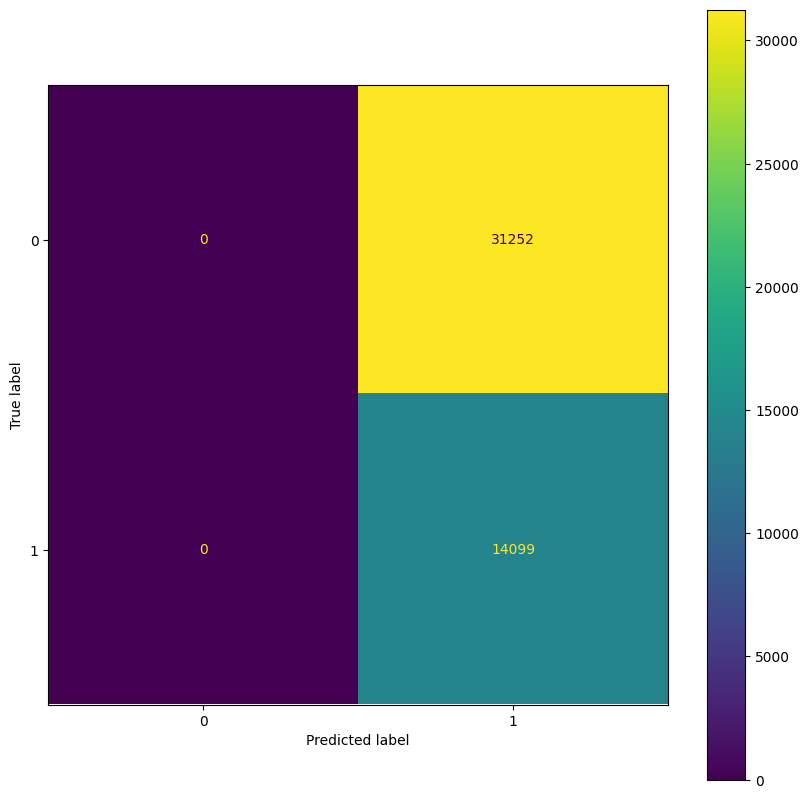

In [133]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=False)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test, verbose=False);
    pred = pred >= 0.5
    
    cm = confusion_matrix(y_test, pred)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)

eval_model(model, test_padded_X1, test_Y)